In [1]:
folder = 'D:/HK5/NLP/UIT-VSMEC-20241212T141641Z-001'

# Thư viện

In [2]:
pip install pyvi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install emoji

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install wikiextractor

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import copy
import gensim
import emoji

from pyvi import ViTokenizer, ViPosTagger
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# Maxent model
from nltk.classify import MaxentClassifier
from nltk.classify.util import accuracy

# Tiền xử lý
(nguồn: https://github.com/hieugiaosu/Vietnamese-Sentiment-Analysis-UIT-VSMEC-DATASET-/blob/main/sentiment.ipynb)


In [6]:
train = pd.read_excel(folder + '/UIT-VSMEC' + '/train_nor_811.xlsx', index_col=0)
# val = pd.read_excel(folder + '/UIT-VSMEC' + '/valid_nor_811.xlsx', index_col=0)
test = pd.read_excel(folder + '/UIT-VSMEC' + '/test_nor_811.xlsx', index_col=0)

In [7]:
train

,Emotion,Sentence
188,Other,cho mình xin bài nhạc tên là gì với ạ
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
825,Other,nhìn mặt héo queo luôn
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
363,Enjoyment,thích thân hình boss rồi nhan 😌


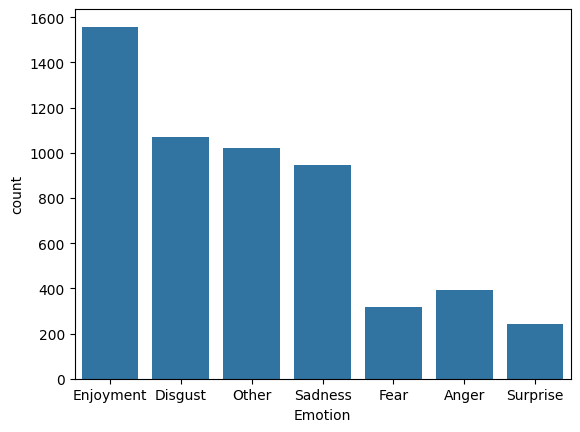

In [8]:
sns.countplot(x='Emotion', data=train, order=test['Emotion'].value_counts().index)
plt.show()

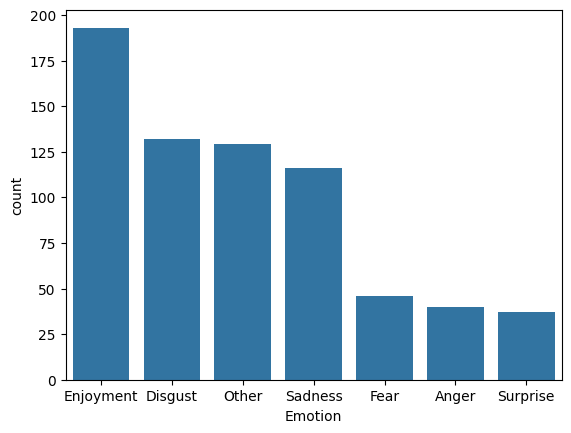

In [9]:
sns.countplot(x='Emotion', data=test, order=test['Emotion'].value_counts().index)
plt.show()

Có thể thấy dữ liệu của tập train và tập test có số nhãn khá mất cân bằng, các nhãn Fear, Anger, Suprise có ít mẫu hơn

In [10]:
stopwords = []
with open('C:/Users/Administrator/Downloads/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.strip())
# stopwords

In [11]:
teencodes = {}
with open(folder + '/teencode.txt','r',encoding='utf-8') as file:
    file = file.read()
    lines = file.split('\n')
    for line in lines:
        elements = line.split('\t')
        if len(elements) == 2:
            teencodes[elements[0]] = elements[1]
# teencodes

In [12]:
def preprocess_teencodes(sentence):
    for key, value in teencodes.items():
        sentence = re.sub(r'\b{}\b'.format(key), value, sentence)
    return sentence

In [13]:
def preprocess_emoji(sentence):
    emotion_dict = {
        '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
        '(-_-)|(-\.-)':'😐',':v':'_pacman_smile_','(:|;|=)+(\'|`|\")+(\)|\]|>)+':'🥲','(:|;|=)+(\'|`|\")+(\(|\[|<)+':'😢',
        '@@':'😵‍💫','đc':'được','đk':'được','bik':'biết','ngừi':'người','hix':'hic','lm':'làm'
    }
    for key, value in emotion_dict.items():
        sentence = re.sub(key,value,sentence)
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r":(.*?):",r" _\1_ ",sentence)
    sentence = re.sub(r'([!@#$%^&*()_+={}:;"\'<>,?/\|~-])\1+',r'\1',sentence)
    return sentence

<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
<>:3: SyntaxWarning: invalid escape sequence '\)'
<>:3: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\)'
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26600\1970431461.py:3: SyntaxWarning: invalid escape sequence '\)'
  '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26600\1970431461.py:3: SyntaxWarning: invalid escape sequence '\('
  '(:|;|=)+(\)|\]|>)+':'🙂','(:|;|=)+(\(|\[|<)+':'😞','(:|;|=)+(D|d)':'😁',
C:\Users\Administrator\AppData\Local\Temp\ipykernel_26600\1970431461.py:4: SyntaxWarning: invalid escape sequence '\

In [14]:
def tokenize(sentence):
    start_token = ' _s_ '
    end_token = ' _e_ '
    sentence = sentence.lower()

    # Preprocess Emoji
    sentence = preprocess_emoji(sentence)

    # Preprocess teencodes
    sentence = preprocess_teencodes(sentence)

    sentence = start_token + sentence + end_token
    return ViTokenizer.tokenize(sentence).split()

In [15]:
def remove_stopwords(words):
    new_words = [word for word in words if re.sub("_", " ", word) not in stopwords]
    return new_words

In [16]:
train['Text'] = train['Sentence'].apply(tokenize)
train['Text'] = train['Text'].apply(remove_stopwords)
train

,Emotion,Sentence,Text
188,Other,cho mình xin bài nhạc tên là gì với ạ,"[_s_, nhạc, _e_]"
166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :)),"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...,...
1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...,"[_s_, đường, nhà_cụ, cụ, cấm, người_ta, đỗ, .,..."
825,Other,nhìn mặt héo queo luôn,"[_s_, mặt, héo, queo, _e_]"
165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...,"[_s_, tao, đi, xe_máy, xe, đi, phi_mẹ, quán, n..."
363,Enjoyment,thích thân hình boss rồi nhan 😌,"[_s_, thân_hình, boss, nhan, _relieved_face_, ..."


In [17]:
test['Text'] = test['Sentence'].apply(tokenize)
test['Text'] = test['Text'].apply(remove_stopwords)
test

,Emotion,Sentence,Text
713,Sadness,người ta có bạn bè nhìn vui thật,"[_s_, người_ta, bạn_bè, vui, _e_]"
1827,Surprise,cho nghỉ viêc mói đúng sao goi là kỷ luật,"[_s_, nghỉ, viêc, mói, goi, kỷ_luật, _e_]"
1166,Disgust,kinh vãi 😡,"[_s_, kinh, vãi, _enraged_face_, _e_]"
228,Fear,nhà thì không xa lắm nhưng chưa bao giờ đi vì ...,"[_s_, lắm, đi, sợ, đè_bẹp, _slightly_smiling_f..."
1942,Anger,bố không thích nộp đấy mày thích ý kiến không,"[_s_, bố, nộp, đấy, mày, ý_kiến, _e_]"
...,...,...,...
432,Sadness,lúc thì cuốc đất è cổ ra không có giun mà câu ...,"[_s_, cuốc, đất, è_cổ, giun, câu, cá, _unamuse..."
178,Enjoyment,các bác dẫn crush qua cây sữa nay mà hứng nước...,"[_s_, crush, sữa, hứng, nước_đái, ve_nha, haha..."
1863,Surprise,vợ chồng rồi mà trong sáng như này chỉ có tron...,"[_s_, vợ_chồng, trong_sáng, phim, _face_with_t..."
476,Other,bep này vào binh dương dùng xuất,"[_s_, bep, binh, dương, xuất, _e_]"


Mã hóa cột Emotion của tập train và tập test sang kiểu số

In [18]:
emotions = set(train['Emotion'])
emotion_to_num = dict({v:k for k,v in enumerate(emotions)})
num_to_emotion = dict({k:v for k,v in enumerate(emotions)})
train['Emotion'] = train['Emotion'].apply(lambda x: emotion_to_num[x])
test['Emotion'] = test['Emotion'].apply(lambda x: emotion_to_num[x])

In [19]:
emotion_to_num

{'Surprise': 0,
 'Sadness': 1,
 'Disgust': 2,
 'Fear': 3,
 'Other': 4,
 'Enjoyment': 5,
 'Anger': 6}

## Data augmentation: các từ ngẫu nhiên trong câu bị thay thế bằng một thẻ đặc biệt (unknown_tag)

In [20]:
def createUnknownData(df,unknown_rate,unknown_tag ='_unk_'):
    mask_df = pd.DataFrame(columns=['Emotion','Text'])
    for row in df.iterrows():
        mask_array = np.random.choice(
            [1,0],size=len(row[1]['Text']),p=[unknown_rate,1-unknown_rate]
        )
        mask_array[0]=0
        mask_array[-1]=0
        if np.sum(mask_array) > 0:
            sentence = copy.deepcopy(row[1]['Text'])
            for idx in range(len(row[1]['Text'])):
                if mask_array[idx] == 1: sentence[idx] = unknown_tag
            mask_df.loc[len(mask_df.index)] = [copy.deepcopy(row[1]['Emotion']),sentence]
    return mask_df

In [21]:
unk_frame = createUnknownData(train,unknown_rate=0.01,unknown_tag ='_unk_')
unk_frame

,Emotion,Text
0,6,"[_s_, ,, đau, huống, ., phẫn_nộ, ., cơ_quan_ch..."
1,2,"[_s_, đòn, tấn_công, _unk_, gắt, cục, sút, _fa..."
2,1,"[_s_, đi, tổng_kết, bắt, học, miết, _unk_, mệt..."
3,4,"[_s_, bồi_thường, thiệt_hại, trầy_xước, thân, ..."
4,6,"[_s_, đéo, tích_sự, _unk_, _e_]"
...,...,...
351,0,"[_s_, giá, ảo, _unk_, _e_]"
352,5,"[_s_, _unk_, _slightly_smiling_face_, _e_]"
353,2,"[_s_, trời_ơi, ổ, đuông, dừa, _unk_, _expressi..."
354,2,"[_s_, đư, ̀, ́, tỏ, la, _unk_, ca, ́, i, ̀, mi..."


In [22]:
new_train_frame = pd.concat([train[['Emotion', 'Text']], unk_frame])
new_train_frame

,Emotion,Text
188,4,"[_s_, nhạc, _e_]"
166,2,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,2,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,5,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,5,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
...,...,...
351,0,"[_s_, giá, ảo, _unk_, _e_]"
352,5,"[_s_, _unk_, _slightly_smiling_face_, _e_]"
353,2,"[_s_, trời_ơi, ổ, đuông, dừa, _unk_, _expressi..."
354,2,"[_s_, đư, ̀, ́, tỏ, la, _unk_, ca, ́, i, ̀, mi..."


corpus: danh sách các câu, mỗi câu là một danh sách các từ (đã được xử lý trước như loại bỏ dấu câu, chuyển chữ thường, tách từ)

In [23]:
corpus = []
for sentence in new_train_frame['Text']:
  corpus.append(sentence)
len(corpus)

5904

In [24]:
start_token = '_s_'
end_token = '_e_'
unknown_token = '_unk_'

## Balance data - Xử lý dữ liệu mất cân bằng

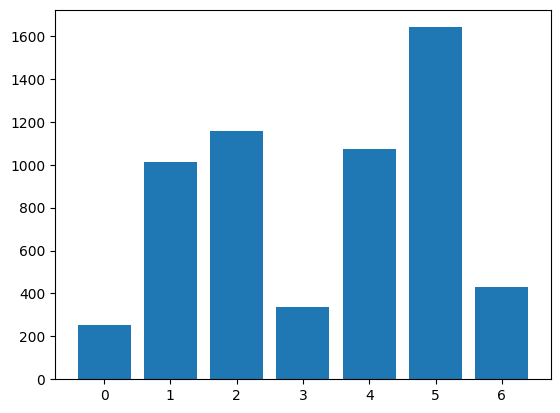

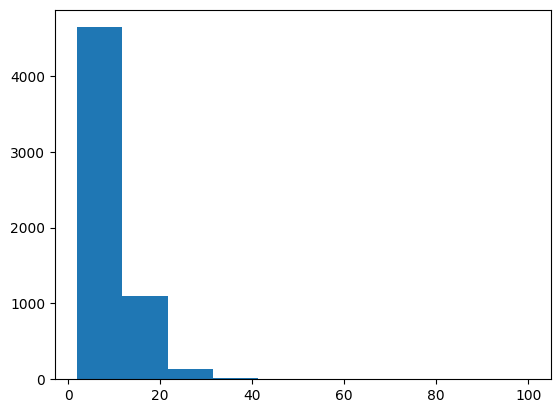

In [25]:
plt.bar(new_train_frame['Emotion'].value_counts().index, new_train_frame['Emotion'].value_counts().values)
plt.show()
plt.hist(new_train_frame['Text'].apply(len))
plt.show()

Phương pháp random undersampling: Giảm tỷ lệ mẫu dữ liệu thuộc một cảm xúc cụ thể trong tập huấn luyện (train) và sau đó chuyển một phần dữ liệu bị loại bỏ sang tập kiểm tra (test)

Thực hiện undersampling với các mẫu có nhãn là Enjoyment vì nhãn này xuất hiện nhiều nhất trong tập train

In [26]:
drop_lst = []
for i in new_train_frame.index[new_train_frame['Emotion']==emotion_to_num['Enjoyment']]:
  if np.random.uniform(0,1)<0.4: # random dưới 40% mẫu trong tập train có nhãn là 'Enjoyment'
    drop_lst.append(i)

drop_df = new_train_frame[new_train_frame.index.isin(drop_lst)]
train_df = new_train_frame.drop(new_train_frame.index[drop_lst])
test_df = pd.concat([test,drop_df])

In [27]:
duplicate = new_train_frame[
    (new_train_frame['Emotion']==emotion_to_num['Anger']) |
    (new_train_frame['Emotion']==emotion_to_num['Fear']) |
    (new_train_frame['Emotion']==emotion_to_num['Surprise'])
]
train_df = pd.concat([train_df,duplicate,duplicate])

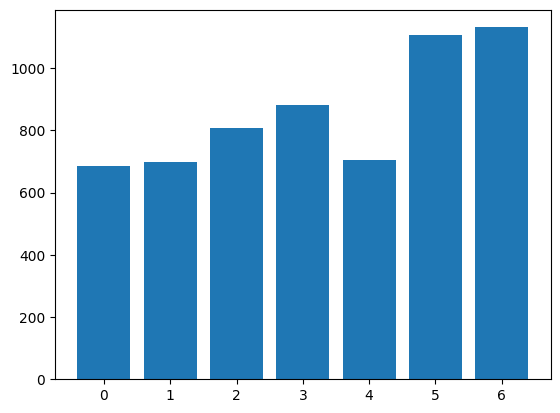

In [28]:
plt.bar(train_df['Emotion'].value_counts().index, train_df['Emotion'].value_counts().values)
plt.show()

Data cân bằng hơn

In [29]:
train_df

,Emotion,Text
166,2,"[_s_, đáng_đời, quỷ, ., lôi, mày, đánh, _enrag..."
1345,2,"[_s_, lo, học, đi, ., yêu_đương, lồn, học_sinh..."
316,5,"[_s_, uớc, già, cụ, _slightly_smiling_face_, _e_]"
1225,5,"[_s_, video, coi, đi, coi, hoài, ., cưng, ., _e_]"
44,4,"[_s_, lí_do, muôn_vàn, lí_do, _e_]"
...,...,...
338,6,"[_s_, địt_mẹ, ,, làm_khách_sạn, ,, check, phòn..."
344,6,"[_s_, per, suốt, bắt, người_ta, đi, tập, gym, ..."
346,6,"[_s_, mấy, mấy, thằng, xe, tông, lát, bét, đi,..."
348,3,"[_s_, ôiii, vãi, ,, dume, tao, sợ, ., nhện, _u..."


In [30]:
test_df.shape

(2868, 3)

# Word2Vec

training Word2Vec

In [31]:
model = gensim.models.Word2Vec(corpus,vector_size=100, window=5, min_count=1, workers=4,epochs=100)

In [32]:
# Lưu model word2vec vào file pickle
with open(folder + '/word2vec_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [33]:
# key_to_index = model.wv.key_to_index
# index_to_key = model.wv.index_to_key

In [34]:
def get_sentence_vector(sentence):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if word_vectors:
        return sum(word_vectors) / len(word_vectors)
    else:
        return [0] * model.vector_size  # Trả về vector 0 nếu không có từ nào trong mô hình

# Áp dụng hàm cho toàn bộ cột 'processed_text' để có được vector cho mỗi câu
train_df['vector'] = train_df['Text'].apply(get_sentence_vector)
test_df['vector'] = test_df['Text'].apply(get_sentence_vector)

In [35]:
X = np.vstack(train_df['vector'].values)
y = train_df['Emotion']

X_test_data = np.vstack(test_df['vector'].values)

Tối ưu hóa siêu tham số của Logistic Regression và SVM dùng k-fold cross validation (Word2Vec)

In [36]:
# Số folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Tối ưu tham số
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Lưu kết quả
best_params = {}
results = {}

# Logistic Regression
print("Tuning Logistic Regression...")
best_accuracy_lr = 0
for C in param_grid_lr['C']:
    accuracies = []
    for train_index, val_index in kf.split(X):
        # Chia dữ liệu train/test
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train model
        model = LogisticRegression(C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

    # Lưu tham số tốt nhất
    mean_acc = np.mean(accuracies)
    if mean_acc > best_accuracy_lr:
        best_accuracy_lr = mean_acc
        best_params['Logistic Regression'] = {'C': C}

print(f"Best Logistic Regression params: {best_params['Logistic Regression']}")
print(f"Accuracy: {best_accuracy_lr:.4f}")

# SVM
print("\nTuning SVM...")
best_accuracy_svm = 0
for C in param_grid_svm['C']:
    for kernel in param_grid_svm['kernel']:
        accuracies = []
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/test
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Train model
            model = SVC(C=C, kernel=kernel)
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            accuracies.append(acc)

        # Lưu tham số tốt nhất
        mean_acc = np.mean(accuracies)
        if mean_acc > best_accuracy_svm:
            best_accuracy_svm = mean_acc
            best_params['SVM'] = {'C': C, 'kernel': kernel}

print(f"Best SVM params: {best_params['SVM']}")
print(f"Accuracy: {best_accuracy_svm:.4f}")

Tuning Logistic Regression...
Best Logistic Regression params: {'C': 10}
Accuracy: 0.4889

Tuning SVM...
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.6647


In [37]:
# Train the best Logistic Regression model on the entire training data
best_lr_model = LogisticRegression(C=best_params['Logistic Regression']['C'], max_iter=1000)
best_lr_model.fit(X, y)

# Predict on the test data
y_test_pred_lr = best_lr_model.predict(X_test_data)

# Evaluate the model
print('Logistic Regression (Word2Vec)\n')
print(classification_report(test_df['Emotion'], y_test_pred_lr))


# Train the best svm model on the entire training data
best_svm_model = SVC(C=best_params['SVM']['C'], kernel=best_params['SVM']['kernel'])
best_svm_model.fit(X, y)

# Predict on the test data
y_test_pred_svm = best_svm_model.predict(X_test_data)

# Evaluate the model
print()
print('SVM (Word2Vec)\n')
print(classification_report(test_df['Emotion'], y_test_pred_svm))

Logistic Regression (Word2Vec)

              precision    recall  f1-score   support

           0       0.20      0.61      0.30       104
           1       0.66      0.50      0.57       462
           2       0.50      0.30      0.38       521
           3       0.37      0.58      0.45       177
           4       0.43      0.24      0.31       511
           5       0.65      0.61      0.63       906
           6       0.26      0.67      0.38       187

    accuracy                           0.47      2868
   macro avg       0.44      0.50      0.43      2868
weighted avg       0.53      0.47      0.48      2868


SVM (Word2Vec)

              precision    recall  f1-score   support

           0       0.37      0.77      0.50       104
           1       0.78      0.70      0.74       462
           2       0.74      0.68      0.71       521
           3       0.75      0.81      0.78       177
           4       0.68      0.57      0.62       511
           5       0.80      

In [38]:
with open(folder + '/logistic_w2v.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

with open(folder + '/svm_w2v.pkl', 'wb') as file:
    pickle.dump(best_svm_model, file)

Maxent (Word2Vec)

In [39]:
# Chuẩn bị dữ liệu
def format_data_for_maxent(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].tolist())  # Chuyển sang tuple
        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

In [40]:
# Train the best Maxent model on the entire training data
formatted_data = format_data_for_maxent(X, y)

maxent_model = MaxentClassifier.train(formatted_data, algorithm='iis', max_iter=10, trace=0)

# Predict on the test data
X_test_data = np.vstack(test_df['vector'].values)
y_test_pred_maxent = [maxent_model.classify({'features': tuple(vector.tolist())}) for vector in X_test_data]

# Evaluate the model
print(classification_report(test_df['Emotion'], y_test_pred_maxent))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       104
           1       1.00      0.51      0.68       462
           2       1.00      0.53      0.69       521
           3       0.99      0.73      0.84       177
           4       1.00      0.51      0.68       511
           5       0.99      0.55      0.71       906
           6       0.14      1.00      0.24       187

    accuracy                           0.58      2868
   macro avg       0.83      0.64      0.65      2868
weighted avg       0.93      0.58      0.67      2868



In [41]:
with open(folder + '/maxent_w2v.pkl', 'wb') as file:
    pickle.dump(maxent_model, file)

# TF-IDF

In [42]:
# Các tham số để thử nghiệm
param_grid_lr = {'C': [0.1, 1, 10]}  # Logistic Regression
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}  # SVM

# Khởi tạo k-fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Hàm thực hiện k-fold cross-validation với TF-IDF vectorizer
def cross_validate_with_tfidf(model, params, X_raw, y, kf):
    best_params = None
    best_score = 0
    results = []

    for param in params:
        scores = []

        # K-fold cross-validation
        for train_index, val_index in kf.split(X_raw):
            # Tách dữ liệu train/test theo fold
            X_train_raw = [X_raw[i] for i in train_index]
            X_val_raw = [X_raw[i] for i in val_index]
            y_train = y.iloc[train_index]
            y_val = y.iloc[val_index]

            # Áp dụng TF-IDF vectorizer trên tập train và test trong fold này
            vectorizer = TfidfVectorizer()
            X_train = vectorizer.fit_transform([' '.join(text) for text in X_train_raw])
            X_val = vectorizer.transform([' '.join(text) for text in X_val_raw])

            # Cập nhật tham số cho model
            model.set_params(**param)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            scores.append(accuracy_score(y_val, y_pred))

        # Tính điểm trung bình cho bộ tham số
        avg_score = np.mean(scores)
        results.append((param, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = param

    return best_params, best_score, results


# Chuẩn bị dữ liệu
X_raw = train_df['Text'].tolist()
y = train_df['Emotion']

# Logistic Regression
lr_params = [{'C': c} for c in param_grid_lr['C']]
lr_model = LogisticRegression(max_iter=1000)
print("Tuning Logistic Regression...")
best_params_lr, best_score_lr, results_lr = cross_validate_with_tfidf(lr_model, lr_params, X_raw, y, kf)
print(f"Best Logistic Regression params: {best_params_lr}")
print(f"Accuracy: {best_score_lr}")

# SVM
svm_params = [{'C': c, 'kernel': k} for c in param_grid_svm['C'] for k in param_grid_svm['kernel']]
svm_model = SVC()
print("\nTuning SVM...")
best_params_svm, best_score_svm, results_svm = cross_validate_with_tfidf(svm_model, svm_params, X_raw, y, kf)
print(f"Best SVM params: {best_params_svm}")
print(f"Accuracy: {best_score_svm}")

Tuning Logistic Regression...
Best Logistic Regression params: {'C': 10}
Accuracy: 0.7042871779576528

Tuning SVM...
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.735869214008169


In [43]:
# Khởi tạo TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

In [44]:
# Train the best Logistic Regression model on the entire training data
best_lr_model = LogisticRegression(C=best_params_lr['C'], max_iter=1000)
best_lr_model.fit(X_train_tfidf, y)

# Predict on the test data
y_test_pred_tf_lr = best_lr_model.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression (TF-IDF) - Best Model:")
print(classification_report(test_df['Emotion'], y_test_pred_tf_lr))


# Train the best SVM model on the entire training data
best_svm_model = SVC(C=best_params_svm['C'], kernel=best_params_svm['kernel'])
best_svm_model.fit(X_train_tfidf, y)

# Predict on the test data
y_test_pred_tf_svm = best_svm_model.predict(X_test_tfidf)

# Evaluate the model
print("\nSVM (TF-IDF) - Best Model:")
print(classification_report(test_df['Emotion'], y_test_pred_tf_svm))

Logistic Regression (TF-IDF) - Best Model:
              precision    recall  f1-score   support

           0       0.43      0.79      0.55       104
           1       0.83      0.77      0.80       462
           2       0.81      0.70      0.75       521
           3       0.73      0.89      0.80       177
           4       0.70      0.62      0.66       511
           5       0.85      0.82      0.83       906
           6       0.62      0.86      0.72       187

    accuracy                           0.76      2868
   macro avg       0.71      0.78      0.73      2868
weighted avg       0.78      0.76      0.76      2868


SVM (TF-IDF) - Best Model:
              precision    recall  f1-score   support

           0       0.51      0.78      0.61       104
           1       0.84      0.79      0.82       462
           2       0.81      0.77      0.79       521
           3       0.91      0.88      0.89       177
           4       0.72      0.67      0.69       511
       

In [45]:
with open(folder + '/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

with open(folder + '/logistic_tfidf.pkl', 'wb') as file:
    pickle.dump(best_lr_model, file)

with open(folder + '/svm_tfidf.pkl', 'wb') as file:
    pickle.dump(best_svm_model, file)

Maxent (TF-IDF)

In [46]:
# MaxEnt
# Prepare data for MaxentClassifier with TF-IDF features
def format_data_for_maxent_tfidf(X, y):
    formatted_data = []
    for i in range(X.shape[0]):
        features = tuple(X[i].toarray()[0].tolist())
        # Use .iloc to access the element by position
        formatted_data.append(({'features': features}, y.iloc[i]))
    return formatted_data

# Fit và transform dữ liệu huấn luyện
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in train_df['Text']])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in test_df['Text']])

train_data_tfidf = format_data_for_maxent_tfidf(X_train_tfidf, train_df['Emotion'])
test_data_tfidf = format_data_for_maxent_tfidf(X_test_tfidf, test_df['Emotion'])

maxent_classifier_tfidf = MaxentClassifier.train(train_data_tfidf, trace=0, algorithm='iis', max_iter=10)

predictions_tfidf = [maxent_classifier_tfidf.classify({'features': tuple(vector.toarray()[0].tolist())}) for vector in X_test_tfidf]

print("\nMaxEnt (TF-IDF):")
print(classification_report(test_df['Emotion'], predictions_tfidf))
print("Accuracy:", accuracy(maxent_classifier_tfidf, test_data_tfidf))


MaxEnt (TF-IDF):
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       104
           1       1.00      0.45      0.62       462
           2       1.00      0.41      0.58       521
           3       0.98      0.54      0.70       177
           4       0.99      0.44      0.61       511
           5       0.99      0.47      0.64       906
           6       0.12      1.00      0.21       187

    accuracy                           0.49      2868
   macro avg       0.80      0.56      0.56      2868
weighted avg       0.92      0.49      0.59      2868

Accuracy: 0.49442119944211993


In [47]:
with open(folder + '/maxent_tfidf.pkl', 'wb') as file:
    pickle.dump(maxent_classifier_tfidf, file)

LSTM

In [48]:
# Import thêm các thư viện cần thiết cho Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. Chuẩn bị dữ liệu

# Lấy danh sách các từ trong corpus (tập huấn luyện)
corpus = train_df['Text'].tolist()

# Tạo Word2Vec từ gensim (nếu chưa có)
# Nếu đã có model Word2Vec, bạn có thể load từ file
model = gensim.models.Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4, epochs=100)

# Chuyển các từ thành embedding matrix
vocab_size = len(model.wv.index_to_key) + 1  # Thêm 1 cho padding token
embedding_dim = model.vector_size  # Kích thước vector embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: index for index, word in enumerate(model.wv.index_to_key, start=1)}
for word, index in word_index.items():
    embedding_matrix[index] = model.wv[word]

# Hàm chuyển câu thành danh sách số (dựa vào Word2Vec index)
def sentence_to_sequence(sentence, word_index, max_len):
    sequence = [word_index.get(word, 0) for word in sentence]  # 0 nếu từ không có trong Word2Vec
    return sequence[:max_len] + [0] * max(0, max_len - len(sequence))  # Padding

# Định nghĩa độ dài tối đa của câu
max_len = 50  # Có thể thay đổi tùy dữ liệu

# Chuyển train/test thành các sequence
X_train_seq = np.array([sentence_to_sequence(sentence, word_index, max_len) for sentence in train_df['Text']])
X_test_seq = np.array([sentence_to_sequence(sentence, word_index, max_len) for sentence in test_df['Text']])

# Chuẩn bị nhãn
y_train = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

# 2. Xây dựng mô hình LSTM
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# 3. Huấn luyện mô hình
batch_size = 32
epochs = 10

history = model_lstm.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

# 4. Đánh giá mô hình
loss, accuracy = model_lstm.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model_lstm.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=num_to_emotion.values()))

# 5. Lưu mô hình
model_lstm.save(folder + '/lstm_emotion_model.h5')

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       496,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,500 (1.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 496,500 (1.89 MB)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.2783 - loss: 1.8050 - val_accuracy: 0.4421 - val_loss: 1.5072
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4581 - loss: 1.4788 - val_accuracy: 0.4948 - val_loss: 1.4393
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5014 - loss: 1.3822 - val_accuracy: 0.4861 - val_loss: 1.3521
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5394 - loss: 1.2947 - val_accuracy: 0.5544 - val_loss: 1.2424
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5622 - loss: 1.2201 - val_accuracy: 0.5331 - val_loss: 1.2564
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5928 - loss: 1.1670 - val_accuracy: 0.5568 - val_loss: 1.1960
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.6079 - loss: 1.0814 - val_accuracy: 0.5903 - val_loss: 1.1213
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6260 - loss: 1.0404 - val_accu

Classification Report:
              precision    recall  f1-score   support

    Surprise       0.37      0.67      0.48       104
     Sadness       0.73      0.61      0.67       462
     Disgust       0.54      0.50      0.52       521
        Fear       0.73      0.78      0.75       177
       Other       0.50      0.39      0.44       511
   Enjoyment       0.70      0.70      0.70       906
       Anger       0.49      0.84      0.62       187

    accuracy                           0.61      2868
   macro avg       0.58      0.64      0.60      2868
weighted avg       0.62      0.61      0.61      2868



In [49]:
pip install transformers tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# 1. Chuẩn bị dữ liệu

# Tạo danh sách các câu từ tập huấn luyện
training_sentences = train_df['Text'].tolist()

# Tạo mô hình Word2Vec từ gensim
word2vec_model = gensim.models.Word2Vec(training_sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=100)

# Tạo ma trận embedding
vocab_size = len(word2vec_model.wv.index_to_key) + 1  # Thêm 1 cho padding token
embedding_dimension = word2vec_model.vector_size  # Kích thước vector embedding
embedding_matrix = np.zeros((vocab_size, embedding_dimension))

word_index_mapping = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key, start=1)}
for word, index in word_index_mapping.items():
    embedding_matrix[index] = word2vec_model.wv[word]

# Hàm chuyển đổi câu thành danh sách số (dựa vào index trong Word2Vec)
def convert_sentence_to_sequence(sentence, word_index_mapping, max_length):
    sequence = [word_index_mapping.get(word, 0) for word in sentence]  # 0 nếu từ không có trong Word2Vec
    return sequence[:max_length] + [0] * max(0, max_length - len(sequence))  # Padding

# Định nghĩa độ dài tối đa của câu
max_length = 50  # Có thể thay đổi tùy thuộc vào dữ liệu

# Chuyển đổi tập huấn luyện và kiểm tra thành các sequence
X_train_sequences = np.array([convert_sentence_to_sequence(sentence, word_index_mapping, max_length) for sentence in train_df['Text']])
X_test_sequences = np.array([convert_sentence_to_sequence(sentence, word_index_mapping, max_length) for sentence in test_df['Text']])

# Chuẩn bị nhãn
y_train_labels = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test_labels = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

# 2. Xây dựng mô hình LSTM
lstm_model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dimension, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# 3. Huấn luyện mô hình
batch_size_value = 34
epochs_value = 10

training_history = lstm_model.fit(
    X_train_sequences, y_train_labels,
    validation_data=(X_test_sequences, y_test_labels),
    batch_size=batch_size_value,
    epochs=epochs_value,
    verbose=1
)

loss_value, accuracy_value = lstm_model.evaluate(X_test_sequences, y_test_labels)
print(f"Test Accuracy: {accuracy_value:.4f}")

predicted_labels = lstm_model.predict(X_test_sequences)
predicted_class_labels = np.argmax(predicted_labels, axis=1)
true_class_labels = np.argmax(y_test_labels, axis=1)

# Đảm bảo rằng num_to_emotion chứa các giá trị là chuỗi
target_names = [str(num_to_emotion[key]) for key in sorted(num_to_emotion.keys())]

print("Classification Report:")
print(classification_report(true_class_labels, predicted_class_labels, target_names=target_names))

# 5. Lưu mô hình
lstm_model.save(folder + '/lstm_e_model.h5')

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 100)        │       496,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 931,707 (3.55 MB)

 Trainable params: 434,439 (1.66 MB)

 Non-trainable params: 497,268 (1.90 MB)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.2771 - loss: 1.9183 - val_accuracy: 0.4425 - val_loss: 1.6090
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.4429 - loss: 1.5338 - val_accuracy: 0.4428 - val_loss: 1.5019
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5009 - loss: 1.3697 - val_accuracy: 0.4965 - val_loss: 1.3311
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5595 - loss: 1.2177 - val_accuracy: 0.5377 - val_loss: 1.2397
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6044 - loss: 1.1052 - val_accuracy: 0.5453 - val_loss: 1.2178
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6488 - loss: 0.9639 - val_accuracy: 0.6116 - val_loss: 1.0888
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6759 - loss: 0.9077 - val_accuracy: 0.5938 - val_loss: 1.1577
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7089 - loss: 0.8063 - val_acc

Classification Report:
              precision    recall  f1-score   support

    Surprise       0.36      0.73      0.48       104
     Sadness       0.75      0.62      0.68       462
     Disgust       0.64      0.55      0.59       521
        Fear       0.74      0.85      0.79       177
       Other       0.49      0.51      0.50       511
   Enjoyment       0.73      0.70      0.72       906
       Anger       0.67      0.81      0.73       187

    accuracy                           0.64      2868
   macro avg       0.63      0.68      0.64      2868
weighted avg       0.66      0.64      0.65      2868



In [140]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# 1. Chuẩn bị dữ liệu
# Ensure that 'Text' columns contain strings and convert them to a list of strings
training_sentences = train_df['Text'].astype(str).tolist()
test_sentences = test_df['Text'].astype(str).tolist()

# Tạo ma trận TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Chọn số lượng đặc trưng tối đa
tfidf_vectorizer = TfidfVectorizer() 
X_train_tfidf = tfidf_vectorizer.fit_transform(training_sentences).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_sentences).toarray()

# Chuẩn bị nhãn
y_train_labels = to_categorical(train_df['Emotion'].values, num_classes=len(emotion_to_num))
y_test_labels = to_categorical(test_df['Emotion'].values, num_classes=len(emotion_to_num))

# 2. Xây dựng mô hình LSTM
lstm_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),  # Độ dài của đặc trưng TF-IDF
    Dense(128, activation='relu'),  # Thay vì Embedding, dùng Dense layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(emotion_to_num), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# 3. Huấn luyện mô hình
batch_size_value = 34
epochs_value = 10

training_history = lstm_model.fit(
    X_train_tfidf, y_train_labels,
    validation_data=(X_test_tfidf, y_test_labels),
    batch_size=batch_size_value,
    epochs=epochs_value,
    verbose=1
)

loss_value, accuracy_value = lstm_model.evaluate(X_test_tfidf, y_test_labels)
print(f"Test Accuracy: {accuracy_value:.4f}")

predicted_labels = lstm_model.predict(X_test_tfidf)
predicted_class_labels = np.argmax(predicted_labels, axis=1)
true_class_labels = np.argmax(y_test_labels, axis=1)

# Đảm bảo rằng num_to_emotion chứa các giá trị là chuỗi
target_names = [str(num_to_emotion[key]) for key in sorted(num_to_emotion.keys())]

print("Classification Report:")
print(classification_report(true_class_labels, predicted_class_labels, target_names=target_names))

# 5. Lưu mô hình
lstm_model.save(folder + '/lstm_tfidf_model.h5')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │       625,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,119 (2.42 MB)

 Trainable params: 634,119 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2444 - loss: 1.8881 - val_accuracy: 0.4637 - val_loss: 1.4927
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6211 - loss: 1.1614 - val_accuracy: 0.6799 - val_loss: 0.9963
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8338 - loss: 0.6194 - val_accuracy: 0.7106 - val_loss: 0.8463
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8922 - loss: 0.3875 - val_accuracy: 0.7538 - val_loss: 0.7667
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9331 - loss: 0.2583 - val_accuracy: 0.7528 - val_loss: 0.7988
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9456 - loss: 0.2113 - val_accuracy: 0.7580 - val_loss: 0.8216
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9572 - loss: 0.1636 - val_accuracy: 0.7605 - val_loss: 0.8634
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 0.1310 - val_accuracy: 0.

              precision    recall  f1-score   support

    Surprise       0.46      0.78      0.58       104
     Sadness       0.78      0.78      0.78       462
     Disgust       0.80      0.69      0.74       521
        Fear       0.77      0.90      0.83       177
       Other       0.69      0.66      0.68       511
   Enjoyment       0.88      0.81      0.84       906
       Anger       0.65      0.85      0.74       187

    accuracy                           0.76      2868
   macro avg       0.72      0.78      0.74      2868
weighted avg       0.78      0.76      0.77      2868



Test - W2V

In [143]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
# Bước 1: Định nghĩa câu cần kiểm tra
input_sentence = "Nay ra đường khoác áo MU như mặc long bào"  # Thay đổi câu theo ý bạn

# Bước 2: Tiền xử lý câu
tokenized_sentence = tokenize(input_sentence)
tokenized_sentence = remove_stopwords(tokenized_sentence)

# Bước 3: Chuyển đổi thành sequence
sequence = convert_sentence_to_sequence(tokenized_sentence, word_index_mapping, max_length)

# Bước 4: Chuyển đổi thành ma trận 2D cho mô hình
padded_sequence = pad_sequences([sequence], maxlen=max_length)

# Bước 5: Tải mô hình
model = load_model(folder + '/lstm_e_model.h5')  # Thay thế bằng đường dẫn thực tế

# Bước 6: Dự đoán
prediction = model.predict(padded_sequence)
predicted_class = np.argmax(prediction)

# Bước 7: Hiển thị kết quả
emotion_labels = ["Disgust", "Sadness", "Anger", "Fear","Suprise","Enjoyment", "Other"]  # Thay đổi theo nhãn của bạn
print(f"Kết quả dự đoán cho câu '{input_sentence}' là: {emotion_labels[predicted_class]}")
print(f"Các xác suất cảm xúc: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Kết quả dự đoán cho câu 'Nay ra đường khoác áo MU như mặc long bào' là: Suprise
Các xác suất cảm xúc: [[8.3742372e-04 3.0886725e-01 1.5970694e-01 4.4206776e-05 3.2757962e-01
  2.0276776e-01 1.9673341e-04]]


Test TF-IDF

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Bước 1: Định nghĩa câu cần kiểm tra
input_sentence = "Nay ra đường khoác áo MU như mặc long bào"
# Bước 2: Tiền xử lý câu
# Giả sử bạn có các hàm preprocess như tokenize và remove_stopwords
tokenized_sentence = tokenize(input_sentence)  # Tokenize câu
tokenized_sentence = remove_stopwords(tokenized_sentence)  # Loại bỏ stopwords

# Bước 3: Chuyển đổi danh sách từ thành chuỗi
preprocessed_sentence = ' '.join(tokenized_sentence)

# Bước 4: Tải mô hình TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Sử dụng cùng số lượng đặc trưng như trước
tfidf_vectorizer.fit(train_df['Text'].astype(str).tolist())  # Huấn luyện TF-IDF trên tập huấn luyện

# Chuyển đổi câu đã tiền xử lý thành vector TF-IDF
input_tfidf = tfidf_vectorizer.transform([preprocessed_sentence]).toarray()

# Bước 5: Tải mô hình
model = load_model(folder + '/lstm_tfidf_model.h5')  # Thay thế bằng đường dẫn thực tế

# Bước 6: Dự đoán
prediction = model.predict(input_tfidf)
predicted_class = np.argmax(prediction)

# Bước 7: Hiển thị kết quả
emotion_labels = ["Anger", "Sadness", "Disgust", "Fear", "Suprise", "Enjoyment", "Other"]  # Thay đổi theo nhãn của bạn
print(f"Kết quả dự đoán cho câu '{input_sentence}' là: {emotion_labels[predicted_class]}")
print(f"Các xác suất cảm xúc: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Kết quả dự đoán cho câu 'Nay ra đường khoác áo MU như mặc long bào' là: Enjoyment
Các xác suất cảm xúc: [[6.8363912e-02 2.2485485e-02 5.6895792e-02 2.2323897e-04 4.7562782e-02
  8.0247259e-01 1.9961153e-03]]
